In [23]:
# For reading netcdf files
import xarray as xr
# Gets EOFs
from eofs.xarray import Eof

In [24]:
# Opening data
dataset = xr.open_dataset('./processed_data/processed_data.nc')

In [25]:
dataset

<xarray.Dataset> Size: 153MB
Dimensions:  (time: 15336, lat: 24, lon: 104, zlev: 1)
Coordinates:
  * time     (time) datetime64[ns] 123kB 1982-01-03T12:00:00 ... 2023-12-29T1...
  * lat      (lat) float64 192B -30.0 -27.5 -25.0 -22.5 ... 20.0 22.5 25.0 27.5
  * lon      (lon) float64 832B 30.0 32.5 35.0 37.5 ... 280.0 282.5 285.0 287.5
Dimensions without coordinates: zlev
Data variables:
    anom     (time, zlev, lat, lon) float32 153MB ...

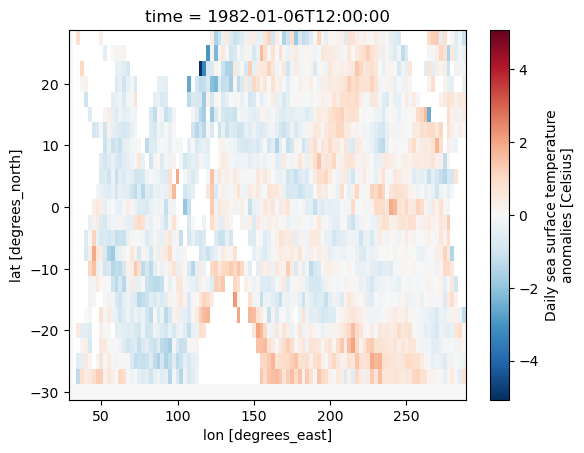

In [26]:
dataset['anom'].isel(zlev=0).isel(time=3).plot()

In [27]:
Eof(dataset['anom'].isel(zlev=0))